#Online News Popularity

## Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import math
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
from dataclasses import dataclass
from scipy import optimize
from scipy.stats import norm
from svm_utils  import *

In [ ]:
#!pip uninstall matplotlib
#!pip install matplotlib==3.6.2

In [ ]:
#import matplotlib
#print('matplotlib: {}'.format(matplotlib.__version__))
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## About the Data

In [ ]:
onp = pd.read_csv('OnlineNewsPopularity.csv')
onp.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [ ]:
onp.shape

(39644, 61)

In [ ]:
onp.isnull().sum()/onp.shape[0]*100

url                              0.0
 timedelta                       0.0
 n_tokens_title                  0.0
 n_tokens_content                0.0
 n_unique_tokens                 0.0
                                ... 
 title_subjectivity              0.0
 title_sentiment_polarity        0.0
 abs_title_subjectivity          0.0
 abs_title_sentiment_polarity    0.0
 shares                          0.0
Length: 61, dtype: float64

In [ ]:
onp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [ ]:
onp.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


In [ ]:
onp.columns=onp.columns.str.replace(" ","")

## Exploratory Data Analysis

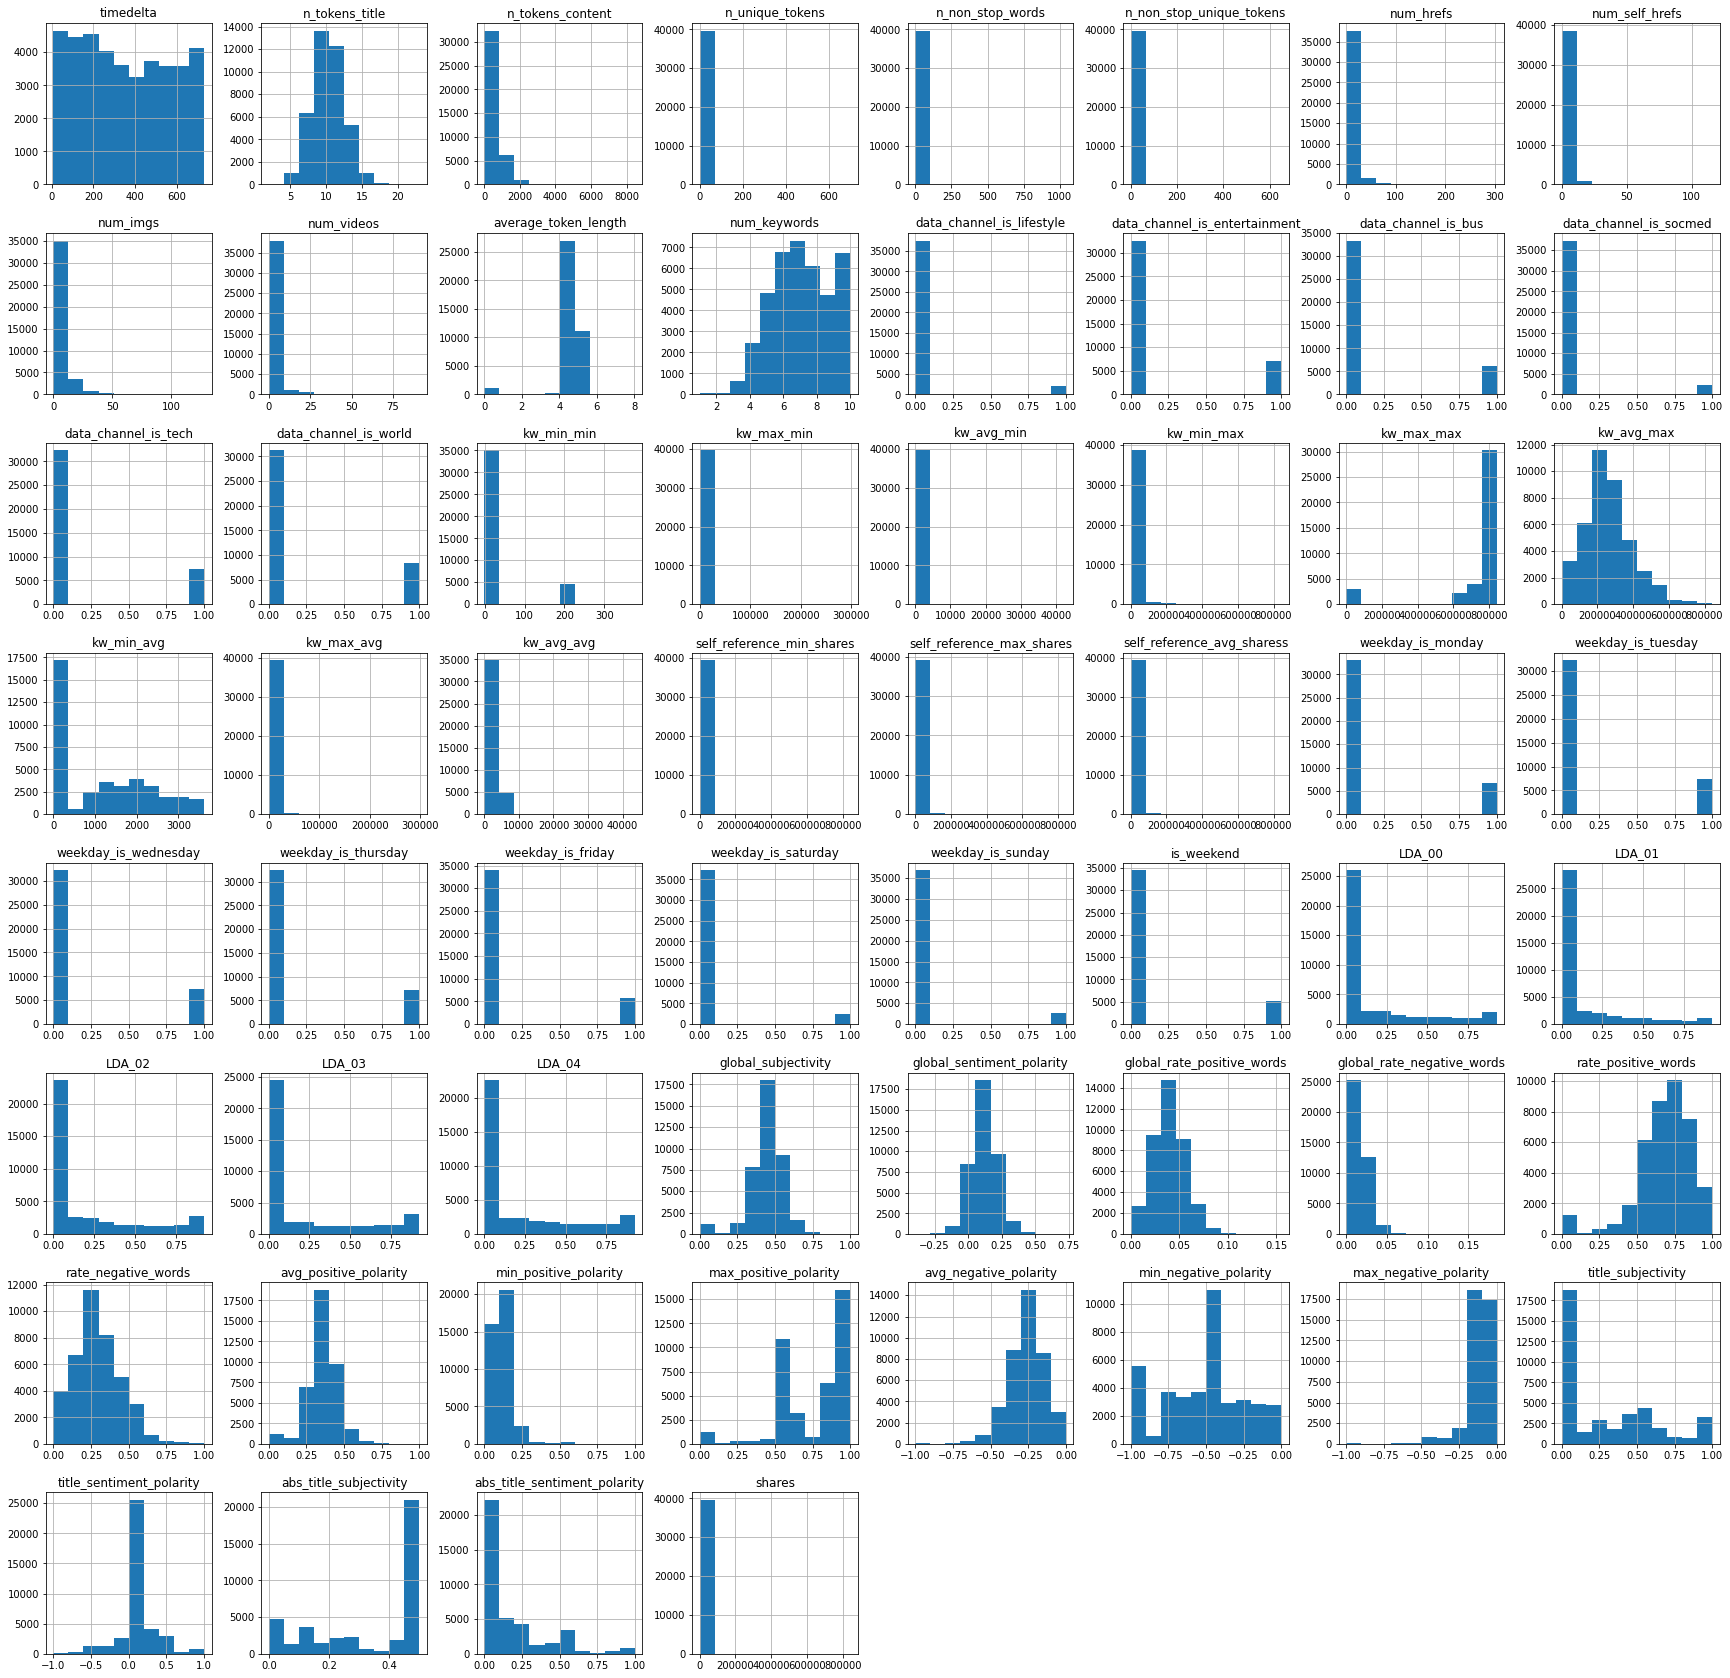

In [ ]:
onp.hist(figsize=(30,30))
plt.show()

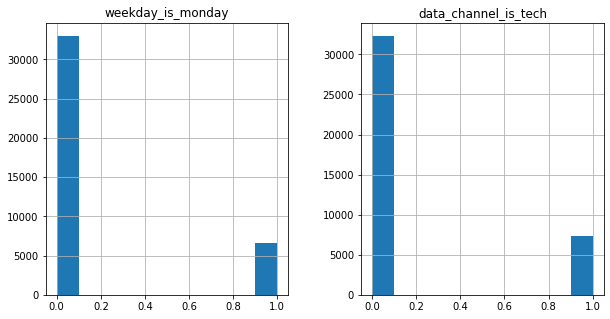

In [ ]:
onp[['weekday_is_monday','data_channel_is_tech']].hist(figsize=(10,5))
plt.show()

In [ ]:
not_popular=onp[onp['shares']<onp['shares'].median()]
popular=onp[onp['shares']>=onp['shares'].median()]

In [ ]:
data_channel=onp.columns[13:19]
data_channel

Index(['data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world'],
      dtype='object')

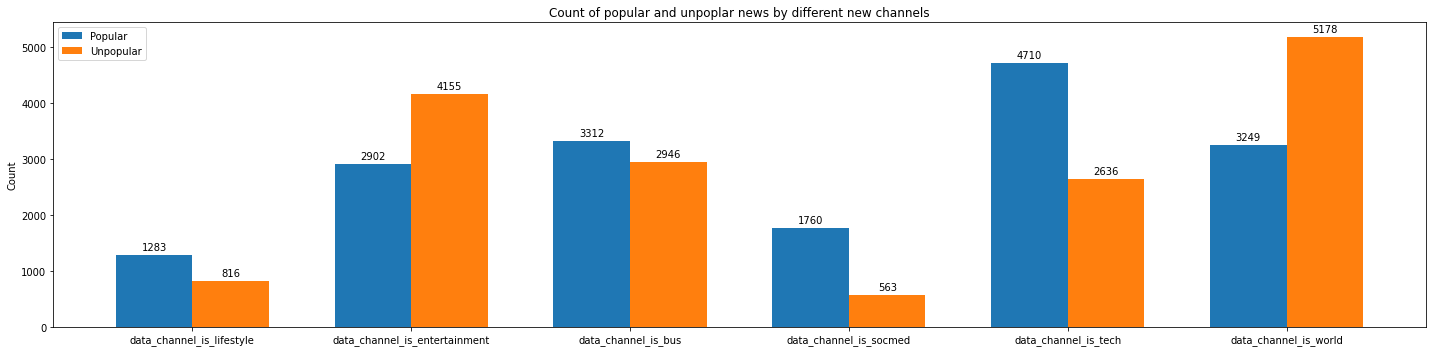

In [ ]:
Unpop_dc = not_popular[data_channel].sum().values
Pop_dc = popular[data_channel].sum().values

x = np.arange(len(data_channel))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(x - width/2, Pop_dc, width, label='Popular')
rects2 = ax.bar(x + width/2, Unpop_dc, width, label='Unpopular')

ax.set_ylabel('Count')
ax.set_title('Count of popular and unpoplar news by different new channels')
plt.xticks(x, data_channel)
ax.legend()

plt.bar_label(rects1, padding=3)
plt.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
attr = onp.iloc[:,[9,10,12]]
values = attr.sum()
values

num_imgs        180148.0
num_videos       49550.0
num_keywords    286379.0
dtype: float64

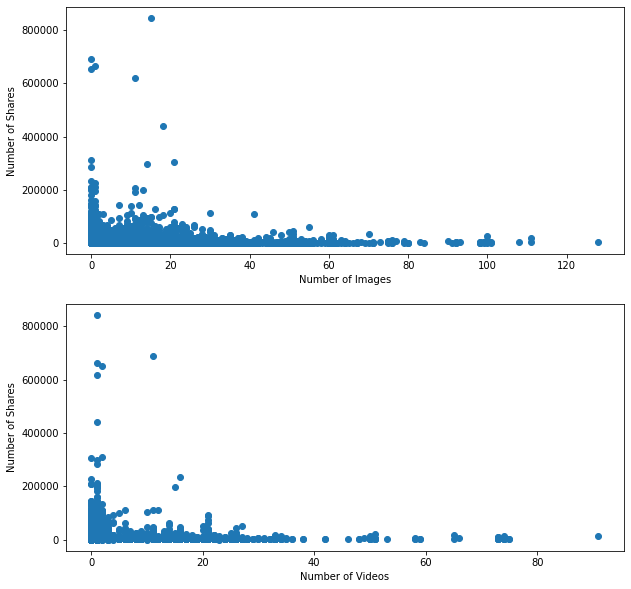

In [ ]:
attr = onp.iloc[:,[9,10]]

fig, ax = plt.subplots(2, figsize=(10, 10))

ax[0].scatter(x = attr.iloc[:,0], y = onp['shares'])
ax[0].set_xlabel("Number of Images")
ax[0].set_ylabel("Number of Shares")

ax[1].scatter(x = attr.iloc[:,1], y = onp['shares'])
ax[1].set_xlabel("Number of Videos")
ax[1].set_ylabel("Number of Shares")

plt.show()

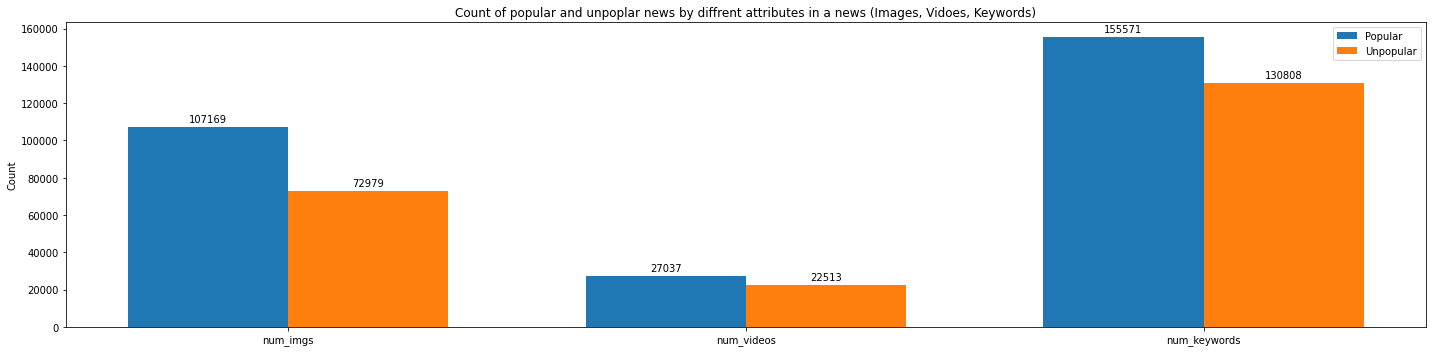

In [ ]:
attr_news= onp.columns[[9,10, 12]]

Unpop_an = not_popular[attr_news].sum().values
Pop_an = popular[attr_news].sum().values

x = np.arange(len(attr_news))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
rects1 = ax.bar(x - width/2, Pop_an, width, label='Popular')
rects2 = ax.bar(x + width/2, Unpop_an, width, label='Unpopular')

ax.set_ylabel('Count')
ax.set_title('Count of popular and unpoplar news by diffrent attributes in a news (Images, Vidoes, Keywords)')
plt.xticks(x,attr_news )

ax.legend()

plt.bar_label(rects1, padding=3)
plt.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
weekdays = onp.columns.values[31:38]
print(weekdays)

['weekday_is_monday' 'weekday_is_tuesday' 'weekday_is_wednesday'
 'weekday_is_thursday' 'weekday_is_friday' 'weekday_is_saturday'
 'weekday_is_sunday']


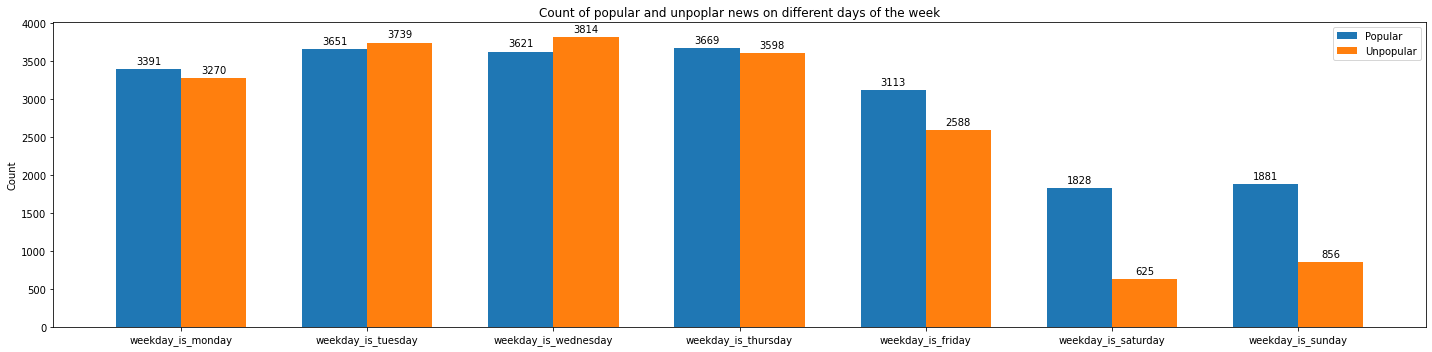

In [ ]:
not_popular_day = not_popular[weekdays].sum().values
popular_day = popular[weekdays].sum().values

x = np.arange(len(weekdays))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
plt.title('Day-wise count of popular and not popular news', fontsize=16)

rects1 = ax.bar(x - width/2, popular_day, width, label='Popular')
rects2 = ax.bar(x + width/2, not_popular_day, width, label='Unpopular')

ax.set_ylabel('Count')
ax.set_title('Count of popular and unpoplar news on different days of the week')
plt.xticks(np.arange(len(weekdays)), weekdays)
ax.legend()

plt.bar_label(rects1, padding=3)
plt.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Feature Engineering

<ipython-input-20-3b23455dbdf7>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  onp1 = cor.where(np.tril(np.ones(cor.shape)).astype(np.bool))


<AxesSubplot: >

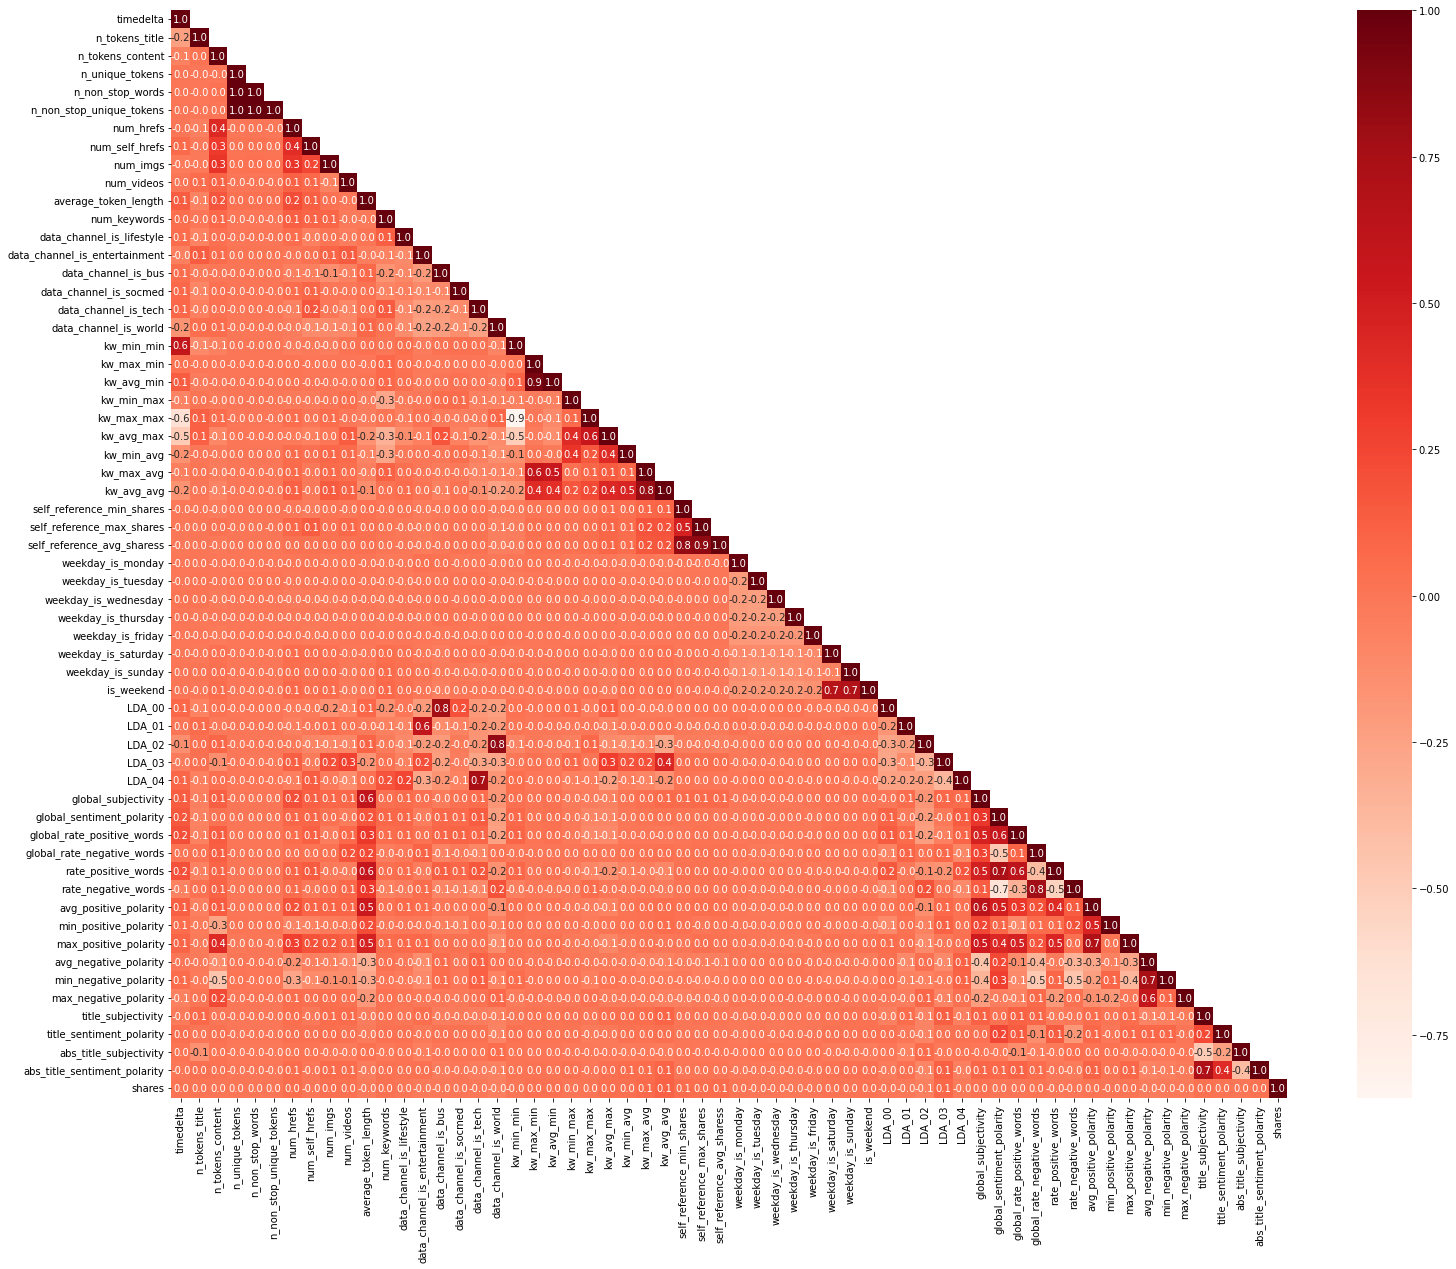

In [ ]:
cor=onp.corr()
plt.figure(figsize=(25,20))
onp1 = cor.where(np.tril(np.ones(cor.shape)).astype(np.bool))
sns.heatmap(onp1,cmap='Reds', annot=True, fmt=".1f")

In [ ]:
# Dropping:
# 'URL' as it is a non-numeric attribute and is not valuable to our analysis
# 'timedelta' as it is not a feature, but a non-predictive attribute
# 'n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min' , 'kw_max_max', 'self_reference_avg_sharess' as they are highly correlated attributes
onp = onp.drop(["url","timedelta","n_non_stop_unique_tokens","n_non_stop_words","kw_avg_min", "kw_max_max", "self_reference_avg_sharess"],axis=1)

In [ ]:
onp.shape

(39644, 54)

<AxesSubplot: >

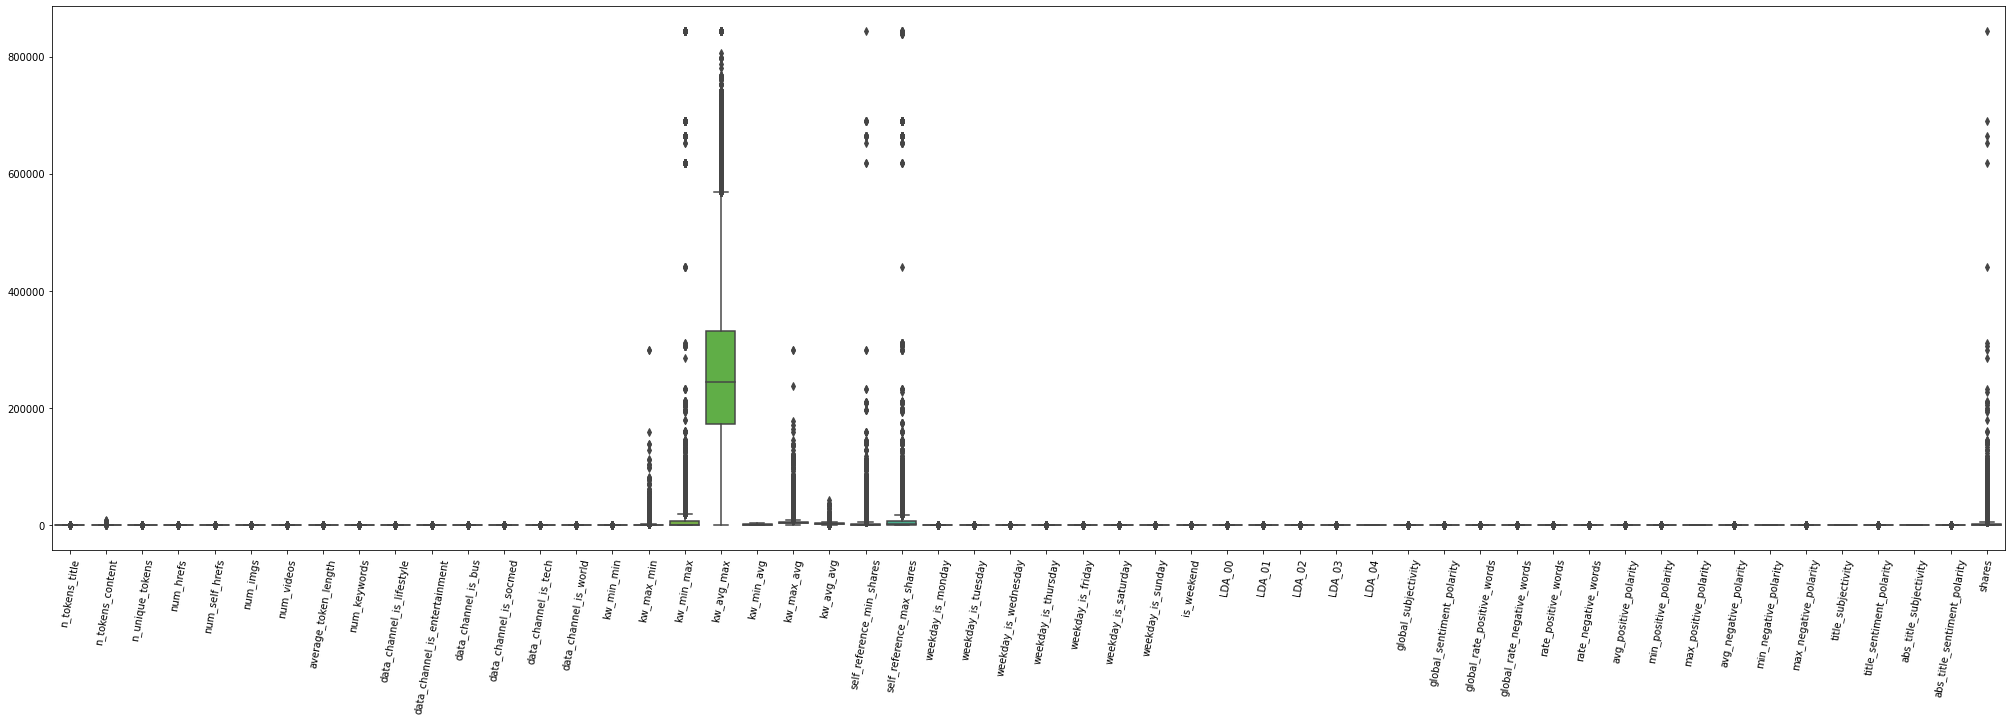

In [ ]:
#numerical = onp.select_dtypes(['int64','float64']).columns
plt.figure(figsize=(35,10))
plt.xticks(rotation=80)
sns.boxplot(data = onp)

In [ ]:
numerical_onp = onp.drop(["data_channel_is_tech","data_channel_is_world","data_channel_is_lifestyle",
                          "data_channel_is_entertainment","data_channel_is_bus", "data_channel_is_socmed",
                          "is_weekend", "weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday",
                          "weekday_is_thursday","weekday_is_friday","weekday_is_saturday","weekday_is_sunday"],axis=1)

categorical_onp = onp[["data_channel_is_tech","data_channel_is_world","data_channel_is_lifestyle",
                       "data_channel_is_entertainment","data_channel_is_bus", "data_channel_is_socmed",
                       "is_weekend", "weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday",
                       "weekday_is_thursday","weekday_is_friday","weekday_is_saturday","weekday_is_sunday"]]

In [ ]:
numerical_onp = numerical_onp.drop('shares',axis=1)

### Feature Transformation

In [ ]:
negative_columns = numerical_onp.columns[(numerical_onp<=0).any()]
negative_columns

Index(['n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'kw_min_min',
       'kw_max_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity'],
      dtype='object')

In [ ]:
#The distribution has a lot of negative values and isn't normal, so will be using box-cox method of scaling
for i in negative_columns:                   #new features are created by converting negative into positive values
    minimum = numerical_onp[i].min()
    new_name = i +'_1'
    numerical_onp[new_name] = ((numerical_onp[i]+1) - minimum)

In [ ]:
for i in negative_columns:
    numerical_onp.drop(i,axis=1,inplace=True) #Dropped old negative columns

In [ ]:
negative_columns = numerical_onp.columns[(numerical_onp<=0).any()]
negative_columns

Index([], dtype='object')

In [ ]:
power_transf=preprocessing.PowerTransformer(method='box-cox',standardize=False)
numerical_onp1=power_transf.fit_transform(numerical_onp)
numerical_onp1=(pd.DataFrame(numerical_onp1,columns=numerical_onp.columns))

### Feature Scaling

In [ ]:
ss = StandardScaler()
numerical_onp[:] = ss.fit_transform(numerical_onp1)

In [ ]:
final_onp_with_outliers=pd.concat([numerical_onp,categorical_onp],axis=1)

<AxesSubplot: >

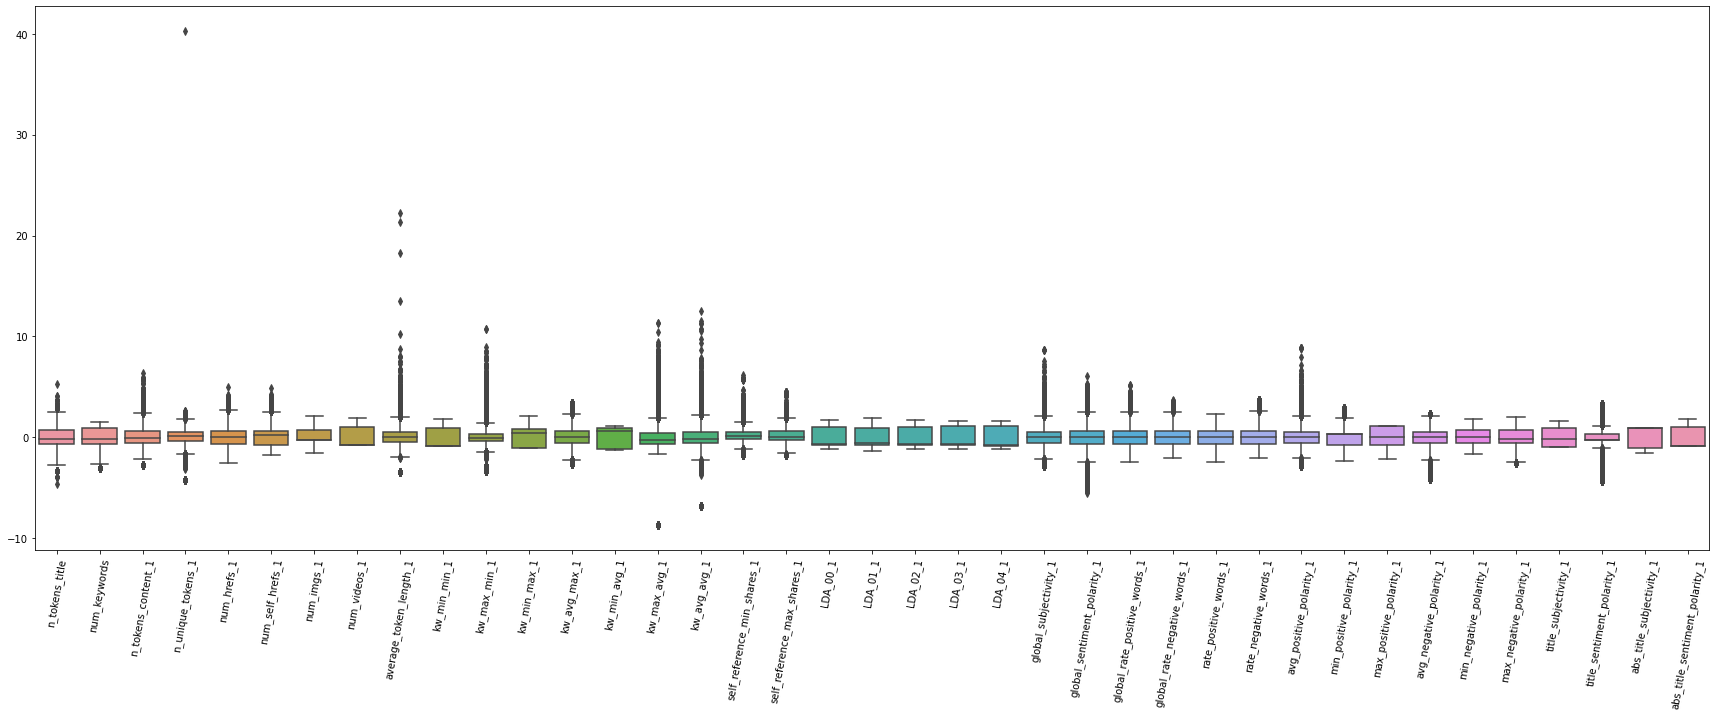

In [ ]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=80)
sns.boxplot(data = numerical_onp)

### Outlier Treatment

In [ ]:
def outlier_treatment(array, k=2):
    ll = array.mean() - k*array.std()
    ul = array.mean() + k*array.std()
    array[array < ll] = ll
    array[array > ul] = ul
    return array

In [ ]:
numerical_onp_without_outliers = numerical_onp.apply(outlier_treatment)

<AxesSubplot: >

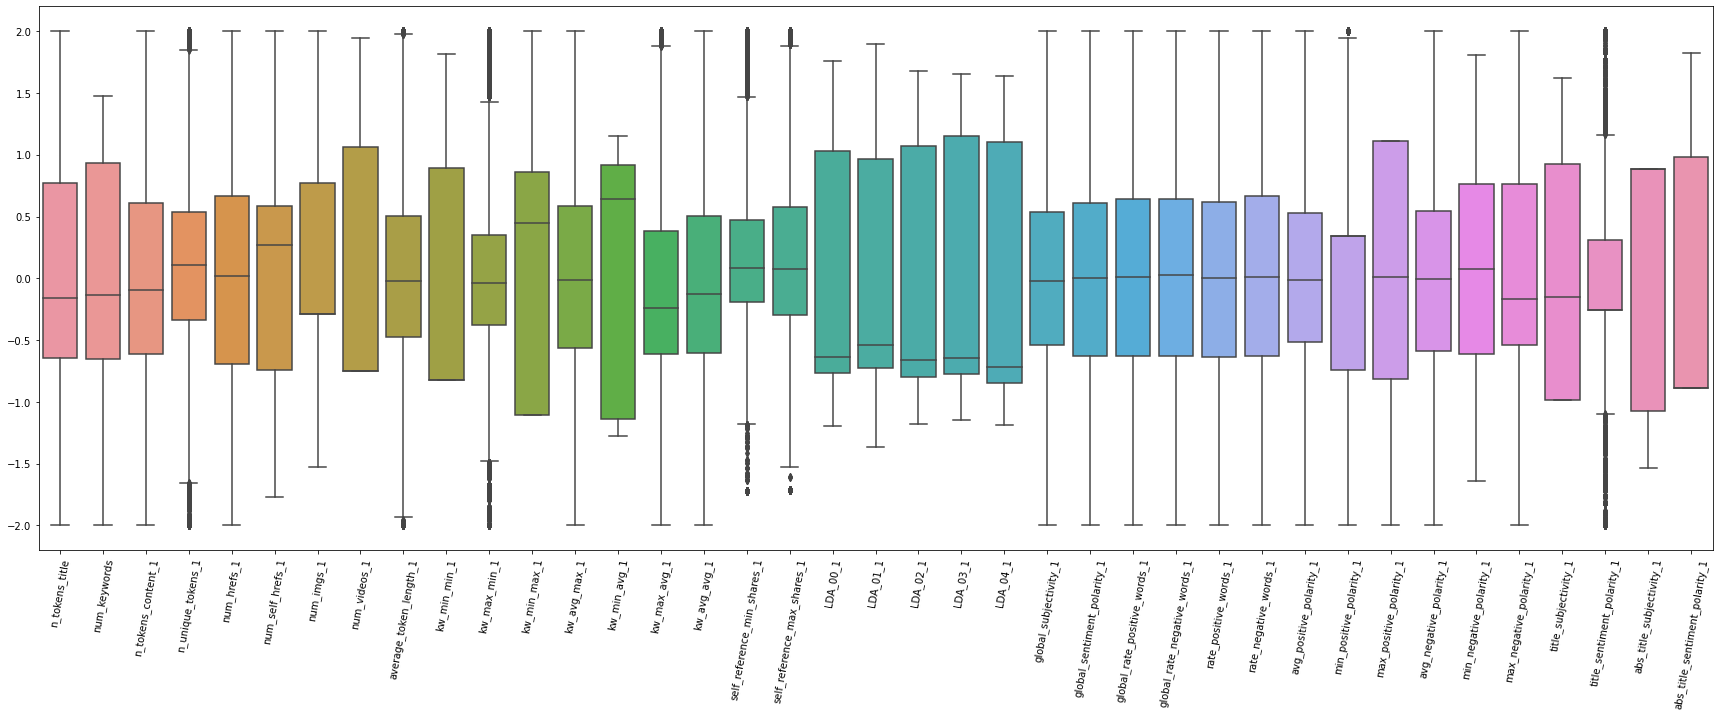

In [ ]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=80)
sns.boxplot(data = numerical_onp_without_outliers)

In [ ]:
final_onp_without_outliers=pd.concat([numerical_onp_without_outliers,categorical_onp],axis=1)

In [ ]:
median = onp['shares'].median()

In [ ]:
final_onp_with_outliers.shape

(39644, 53)

In [ ]:
final_onp_without_outliers.shape

(39644, 53)

In [ ]:
final_onp_with_outliers['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

In [ ]:
final_onp_without_outliers['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

In [ ]:
final_onp_with_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   n_tokens_title                  39644 non-null  float64
 1   num_keywords                    39644 non-null  float64
 2   n_tokens_content_1              39644 non-null  float64
 3   n_unique_tokens_1               39644 non-null  float64
 4   num_hrefs_1                     39644 non-null  float64
 5   num_self_hrefs_1                39644 non-null  float64
 6   num_imgs_1                      39644 non-null  float64
 7   num_videos_1                    39644 non-null  float64
 8   average_token_length_1          39644 non-null  float64
 9   kw_min_min_1                    39644 non-null  float64
 10  kw_max_min_1                    39644 non-null  float64
 11  kw_min_max_1                    39644 non-null  float64
 12  kw_avg_max_1                    

In [ ]:
final_onp_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   n_tokens_title                  39644 non-null  float64
 1   num_keywords                    39644 non-null  float64
 2   n_tokens_content_1              39644 non-null  float64
 3   n_unique_tokens_1               39644 non-null  float64
 4   num_hrefs_1                     39644 non-null  float64
 5   num_self_hrefs_1                39644 non-null  float64
 6   num_imgs_1                      39644 non-null  float64
 7   num_videos_1                    39644 non-null  float64
 8   average_token_length_1          39644 non-null  float64
 9   kw_min_min_1                    39644 non-null  float64
 10  kw_max_min_1                    39644 non-null  float64
 11  kw_min_max_1                    39644 non-null  float64
 12  kw_avg_max_1                    

In [ ]:
X_O = final_onp_with_outliers.drop(['popularity'], axis = 1)
y_O = final_onp_with_outliers['popularity']

In [ ]:
X = final_onp_without_outliers.drop(['popularity'], axis = 1)
y = final_onp_without_outliers['popularity']

### Principle Component Analysis

In [ ]:
numerical_onp.columns

Index(['n_tokens_title', 'num_keywords', 'n_tokens_content_1',
       'n_unique_tokens_1', 'num_hrefs_1', 'num_self_hrefs_1', 'num_imgs_1',
       'num_videos_1', 'average_token_length_1', 'kw_min_min_1',
       'kw_max_min_1', 'kw_min_max_1', 'kw_avg_max_1', 'kw_min_avg_1',
       'kw_max_avg_1', 'kw_avg_avg_1', 'self_reference_min_shares_1',
       'self_reference_max_shares_1', 'LDA_00_1', 'LDA_01_1', 'LDA_02_1',
       'LDA_03_1', 'LDA_04_1', 'global_subjectivity_1',
       'global_sentiment_polarity_1', 'global_rate_positive_words_1',
       'global_rate_negative_words_1', 'rate_positive_words_1',
       'rate_negative_words_1', 'avg_positive_polarity_1',
       'min_positive_polarity_1', 'max_positive_polarity_1',
       'avg_negative_polarity_1', 'min_negative_polarity_1',
       'max_negative_polarity_1', 'title_subjectivity_1',
       'title_sentiment_polarity_1', 'abs_title_subjectivity_1',
       'abs_title_sentiment_polarity_1'],
      dtype='object')

[ 11.70379819  22.0723835   31.22167681  38.62418044  44.83546403
  50.13525943  55.28207143  59.32942006  63.01486078  66.46608678
  69.65559752  72.64604684  75.57957821  78.1040144   80.34317888
  82.380171    84.24769734  85.85067341  87.35201791  88.83665535
  90.22119038  91.44035197  92.56507621  93.59993303  94.53132724
  95.41241455  96.15352714  96.83507685  97.44737645  98.02416433
  98.46874177  98.90417649  99.2095569   99.47964222  99.66877525
  99.82736692  99.90593204  99.967535   100.        ]


Text(0, 0.5, 'cumulative explained variance')

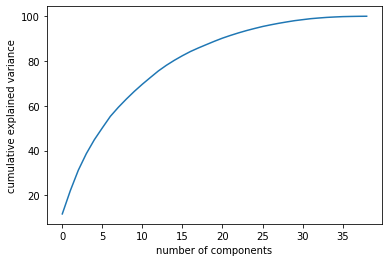

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA(random_state=10)
pca.fit(numerical_onp)

var = pca.explained_variance_ratio_


x = var.cumsum()*100
print(x)

plt.plot(x)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
#Creating PCA datasets

#Dataset with 95% variance captured
pca2 = PCA(random_state=10, n_components=0.95)
df_95_var = pca2.fit_transform(numerical_onp)

# Dataset with 10 numerical features
pca3 = PCA(random_state=10, n_components=10)
df_10_num = pca3.fit_transform(numerical_onp)

# Dataset with 15 numerical features
pca4 = PCA(random_state=10, n_components=15)
df_15_num = pca4.fit_transform(numerical_onp)

<AxesSubplot: xlabel='0', ylabel='1'>

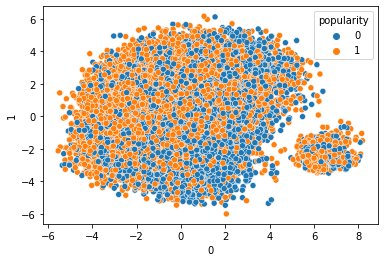

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca5 = PCA(random_state=10, n_components=2)
df_2_num = pd.DataFrame(pca5.fit_transform(numerical_onp))
var5 = pca5.explained_variance_ratio_

df_2_num['popularity'] = onp['shares'].apply(lambda x: 0 if x <1400 else 1)

sns.scatterplot(data=df_2_num, x=0, y=1, hue="popularity")

In [ ]:
final_df_95_var_pca=pd.concat([pd.DataFrame(df_95_var), categorical_onp, onp['shares']],axis=1)
final_df_10_num_pca=pd.concat([pd.DataFrame(df_10_num),categorical_onp, onp['shares']],axis=1)
final_df_15_num_pca=pd.concat([pd.DataFrame(df_15_num),categorical_onp, onp['shares']],axis=1)

### Feature Selection by Lasso Regression

In [ ]:
df_lasso = final_onp_without_outliers.drop(['popularity'], axis = 1)
# Adding shares column for regression
extracted_col = onp["shares"]
df_lasso = pd.concat([df_lasso,extracted_col],axis=1)
df_lasso

,n_tokens_title,num_keywords,n_tokens_content_1,n_unique_tokens_1,num_hrefs_1,num_self_hrefs_1,num_imgs_1,num_videos_1,average_token_length_1,kw_min_min_1,...,data_channel_is_socmed,is_weekend,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,shares
0,0.768020,-1.163789,-0.720956,0.861365,-0.693423,-0.149019,-0.290008,-0.749604,0.022536,0.042133,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,593
1,-0.644129,-1.662899,-0.582079,0.511983,-0.957425,-0.740154,-0.290008,-0.749604,0.677491,0.042133,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2,-0.644129,-0.653274,-0.753699,0.330606,-0.957425,-0.740154,-0.290008,-0.749604,-0.669620,0.042133,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1500
3,-0.644129,-0.133074,0.213271,-0.122812,0.153481,-1.767673,-0.290008,-0.749604,-0.644056,0.042133,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1200
4,1.216370,-0.133074,1.214913,-0.718135,1.042550,2.000025,1.660464,-0.749604,0.029020,0.042133,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.309343,0.395562,-0.277999,0.040511,0.153481,1.251290,-0.290008,1.062406,-0.371357,-0.821801,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1800
39640,0.768020,-0.133074,-0.333828,1.049465,0.153481,1.251290,0.558841,1.944837,-0.642740,-0.821801,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1900
39641,-0.160875,0.395562,-0.007013,-0.041182,1.338081,-0.740154,1.436243,1.062406,1.189318,-0.821801,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1900
39642,-2.000025,-1.163789,0.539768,0.107113,0.273184,-0.740154,-0.290008,-0.749604,0.864498,-0.821801,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1100


In [ ]:
#Lasso feature selection
from pandas.core.groupby.grouper import DataFrame
class LassoFeature:

    def __init__(self, X, y, learningRate, maxIteration, tolerance,
                 regularizationParam, sampleSize, gd = False,
                 L1lassoRegularized= False):

        self.X= X
        self.y = y
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.learningRate = learningRate
        self.regularizationParam = regularizationParam
        self.sampleSize = sampleSize


    def splitData(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            test_size = 0.3,
                                                            random_state=0)

        return X_train, X_test, y_train, y_test

    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])


    def normalize(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)

        X_norm = (X-mean) / std
        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std


    def normalizeTestData(self, X, train_mean, train_std):
        X_norm = (X - train_mean) / train_std
        X_norm = self.add_X0(X_norm)
        return X_norm

    def gradientDescent(self, X, y):
        print('Solving using L1 Lasso regularization')
        if not 0 < self.regularizationParam < 1:
            raise Exception("Sorry, regularizationParam not defined or not in range 0 and 1")

        self.errors = []

        last_error =  float('inf')

        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate * self.costDerivativesForLassoRegularization(X, y)

            current_error = self.sse(X, y)

            diff = last_error - current_error
            last_error = current_error

            self.errors.append(current_error)

            if diff < self.tolerance:
                print("The model stopped learning")
                break


    def predict(self, X):
        self.y_hat =  X.dot(self.w)
        return self.y_hat


    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    def rmse(self, X, y):
        y_hat = self.predict(X)
        return np.sqrt((((y_hat - y) ** 2).sum())/X.shape[0])

    def costFunction(self, X, y):
        return self.sse(X,y) / 2

    def costDerivativesForLassoRegularization(self, X, y):
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y) + self.regularizationParam


    def fit(self):

        X_train, X_test, y_train, y_test = self.splitData()
        X_train ,mean ,std = self.normalize(X_train)
        X_test = self.normalizeTestData(X_test, mean, std)


        print("Solving using Lasso Regularization")
        self.w = np.ones(X_train.shape[1], dtype=np.float64) * 0
        self.gradientDescent(X_train, y_train)

        print("weights : ", self.w)

        ind=[]
        intercept = self.w[0]
        slopes = self.w[1:]
        abs_val= abs(slopes)

        for i in range (0, len(slopes)):
            ind.append(i)

        val = dict(zip(abs_val, ind))
        a = sorted(val.items())

        lasso_index_10=[]
        lasso_index_15 = []
        for x in list(reversed(list(a)))[0:10]:
            lasso_index_10.append(x[1])

        for x in list(reversed(list(a)))[0:15]:
            lasso_index_15.append(x[1])

        final_df_lasso_10 = df_lasso.iloc[:,lasso_index_10 ]
        final_df_lasso_15 = df_lasso.iloc[:,lasso_index_15 ]

        shares_col = df_lasso["shares"]
        final_df_lasso_10 = pd.concat([final_df_lasso_10,shares_col],axis=1)
        final_df_lasso_15 = pd.concat([final_df_lasso_15,shares_col],axis=1)

        return final_df_lasso_10, final_df_lasso_15


regression_lasso_gd = LassoFeature(X = df_lasso.values[:, 0:-1], y = df_lasso.values[:, -1],
                             learningRate=0.00001, tolerance=0.00005,
                             regularizationParam = 0.001,
                             maxIteration = 1000,
                             sampleSize = 100)
final_df_lasso_10, final_df_lasso_15 = regression_lasso_gd.fit()

Solving using Lasso Regularization
Solving using L1 Lasso regularization


100%|██████████| 1000/1000 [00:02<00:00, 374.60it/s]

weights :  [ 3.45134923e+03  2.05208849e+02 -6.35304450e+01 -4.24529715e+02
 -3.58077694e+02  3.96558747e+02 -7.52958256e+02  7.73515363e+01
  4.51433278e+02  1.71318543e+00  4.40985468e+02  2.88085476e+01
 -8.85957104e+02 -1.28758972e+02  5.42184828e+02  1.11467342e+02
  1.11190824e+03 -1.06383502e+02  1.13932767e+03  1.83989030e+02
  2.46939871e+01  6.18604744e+01  1.60861315e+02  1.40604950e+02
  1.78209599e+02  1.74467378e+02 -3.03862414e+02  2.39118859e+02
 -1.53357845e+01 -2.28018648e+02 -2.10472133e+02 -1.94080194e+02
  1.25943012e+02 -2.28467467e+02 -7.22857004e+01 -6.89640746e+01
 -9.39958020e+01 -4.38253199e+01  1.00867727e+02  1.99838058e+02
 -1.40738464e+02 -3.36255590e+02 -3.05440779e+02 -4.72505688e+02
 -1.75334498e+02 -2.07722979e+02  6.67437202e+01  1.56430593e+02
 -1.18922652e+02  3.02384767e+00 -6.26100068e+01 -3.51057469e+01
  7.85588042e+01  1.40588663e+01]


## Regression Models

### Linear Regression

In [ ]:
df_no_outlier = final_onp_without_outliers.drop(['popularity'], axis = 1)
df_baseline = final_onp_with_outliers.drop(['popularity'], axis = 1)
# Adding shares column for regression
extracted_col = onp["shares"]
df_no_outlier = pd.concat([df_no_outlier,extracted_col],axis=1)
df_baseline = pd.concat([df_baseline,extracted_col],axis=1)

In [ ]:
from pandas.core.groupby.grouper import DataFrame
class LinearReg:

    def __init__(self, X, y, learningRate, maxIteration, tolerance,
                 regularizationParam, sampleSize,
                 L2ridgeRegularized = False):

        self.X= X
        self.y = y
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.learningRate = learningRate
        self.L2ridgeRegularized = L2ridgeRegularized
        self.regularizationParam = regularizationParam
        self.sampleSize = sampleSize



    def splitData(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            test_size = 0.3,
                                                            random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                            test_size = 0.3,
                                                            random_state=0)

        return X_train, X_test, y_train, y_test, X_val, y_val

    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])


    def normalize(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)

        X_norm = (X-mean) / std
        X_norm = self.add_X0(X_norm)
        return X_norm, mean, std


    def normalizeTestData(self, X, train_mean, train_std):
        X_norm = (X - train_mean) / train_std
        X_norm = self.add_X0(X_norm)
        return X_norm

    def gradientDescent(self, X, y):

        if self.L2ridgeRegularized:
            print('Solving using L2 Ridge regularization')
            if not 0 < self.regularizationParam < 1:
                raise Exception("Sorry, regularizationParam not defined or not in range 0 and 1")


        self.errors = []

        last_error =  float('inf')

        for i in tqdm(range(self.maxIteration)):
            if not self.L2ridgeRegularized:
                self.w = self.w - self.learningRate * self.costDerivatives(X, y)
            else:
                self.w = self.w - self.learningRate * self.costDerivativesForRegularization(X, y)

            current_error = self.sse(X, y)

            diff = last_error - current_error
            last_error = current_error

            self.errors.append(current_error)

            if diff < self.tolerance:
                print("The model stopped learning")
                break


    def predict(self, X):
        self.y_hat =  X.dot(self.w)
        return self.y_hat


    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    def rmse(self, X, y):
        y_hat = self.predict(X)
        return np.sqrt((((y_hat - y) ** 2).sum())/X.shape[0])

    def mae(self, X, y):
        y_hat = self.predict(X)
        return np.mean(np.abs(y_hat - y))

    def costFunction(self, X, y):
        return self.sse(X,y) / 2

    def costDerivatives(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X)

    def costDerivativesForRegularization(self, X, y):
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y) + self.regularizationParam*(self.w)


    def fit(self):

        X_train, X_test, y_train, y_test, X_val, y_val = self.splitData()

        X_train ,mean ,std = self.normalize(X_train)
        X_test = self.normalizeTestData(X_test, mean, std)
        X_val = self.normalizeTestData(X_val, mean, std)


        print("Solving using Gradient Descent")
        self.w = np.ones(X_train.shape[1], dtype=np.float64) * 0
        self.gradientDescent(X_train, y_train)

        print("weights : ", self.w)


        print("\n")

        print('RMSE for the test dataset : ', self.rmse(X_test, y_test))
        print('MAE for the test dataset : ', self.mae(X_test, y_test))
        print("\n")



In [ ]:
def linearRegAll(df, learningRate, tolerance):
    # without regularization gradient descent form
    regression = LinearReg(X = df.values[:, 0:-1], y = df.values[:, -1],
                             learningRate=learningRate, tolerance=tolerance,
                              maxIteration = 1000,
                             regularizationParam = 0.001, L2ridgeRegularized = False,
                            sampleSize = 150)
    print("---without regularization---")
    regression.fit()
    print("\n\n")


    # with Ridge regularization gd form
    regression_reg_gd = LinearReg(X = df.values[:, 0:-1], y = df.values[:, -1],
                             learningRate=learningRate, tolerance=tolerance,
                             maxIteration = 1000,
                             regularizationParam = 0.001, L2ridgeRegularized = True,
                             sampleSize = 150)
    print("----with Ridge regularization-----")
    regression_reg_gd.fit()
    print("\n")

In [ ]:
# baseline model
linearRegAll(df_baseline, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


100%|██████████| 1000/1000 [00:01<00:00, 535.07it/s]


weights :  [ 3.48702996e+03  1.47955394e+02  8.15906475e+01 -1.33758808e+00
 -2.33321732e+02  3.91082701e+02 -7.46454678e+02  2.94095526e+01
  4.88485173e+02  5.30105315e+01  4.05839235e+02  9.33193298e+01
 -9.81415446e+02 -1.36327554e+02  7.53191668e+02 -3.44645493e+02
  1.26570122e+03  1.55687410e+02  9.92959845e+02  2.74179677e+02
  1.06588068e+02  7.27695647e+01  3.46007868e+02  2.58191919e+02
  1.69864516e+02  1.42855001e+02 -2.94242864e+02  1.83992187e+02
 -1.40380151e+02 -3.01920559e+02 -6.15221890e+01 -2.03677296e+02
 -6.57136478e+00 -2.65108550e+02  8.63062112e+01 -1.09157815e+02
 -1.69002268e+02 -5.27873339e+01  6.95118493e+01  2.65455127e+02
 -3.38682012e+02 -5.10589108e+02 -4.12529241e+02 -6.41091259e+02
 -3.21840834e+02 -3.59625989e+02  7.14063375e+01  1.58803692e+02
 -6.94644378e+01  2.26676980e+01 -1.15995386e+02 -6.03597544e+01
  1.11177130e+02 -1.02885984e+01]


RMSE for the test dataset :  8153.204776372125
MAE for the test dataset :  3066.076795326216





----with R

100%|██████████| 1000/1000 [00:01<00:00, 540.98it/s]

weights :  [ 3.48702978e+03  1.47955364e+02  8.15906969e+01 -1.33776204e+00
 -2.33321842e+02  3.91082701e+02 -7.46454534e+02  2.94095668e+01
  4.88485158e+02  5.30105022e+01  4.05839172e+02  9.33195510e+01
 -9.81412451e+02 -1.36327470e+02  7.53188925e+02 -3.44644974e+02
  1.26570045e+03  1.55687564e+02  9.92959594e+02  2.74179530e+02
  1.06588058e+02  7.27694101e+01  3.46007918e+02  2.58191764e+02
  1.69864559e+02  1.42854868e+02 -2.94242545e+02  1.83991745e+02
 -1.40380152e+02 -3.01920112e+02 -6.15221257e+01 -2.03677296e+02
 -6.57134013e+00 -2.65108415e+02  8.63061071e+01 -1.09157828e+02
 -1.69002186e+02 -5.27873177e+01  6.95118538e+01  2.65455045e+02
 -3.38681806e+02 -5.10588962e+02 -4.12529090e+02 -6.41091174e+02
 -3.21840651e+02 -3.59625836e+02  7.14063368e+01  1.58803690e+02
 -6.94644344e+01  2.26676928e+01 -1.15995388e+02 -6.03597475e+01
  1.11177125e+02 -1.02885942e+01]


RMSE for the test dataset :  8153.204759093518
MAE for the test dataset :  3066.0766621592834






In [ ]:
# after outlier dataset
linearRegAll(df_no_outlier, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


100%|██████████| 1000/1000 [00:01<00:00, 561.83it/s]


weights :  [ 3487.02996139   155.62499059   -21.06543896  -493.13234691
  -505.81551255   384.68733583  -772.62648442    16.71571673
   495.79071415    50.98295359   448.03130805    72.40782067
 -1032.82947684  -145.79871043   774.11331288    94.25048481
  1136.16513383  -274.83909204  1343.59506705   271.30368474
   101.93173535   111.21833116   268.64559273   286.91041887
   164.70196109    38.56646947  -293.49771196   240.35056746
   358.45226459    63.10330556   -71.78781324  -237.2657291
    69.29149153  -139.42040552   -53.08028921  -111.89379086
  -158.17721776   -51.81059024    81.91017987   267.20532649
  -265.75062134  -414.8201776   -384.01755435  -557.66035614
  -257.33034114  -346.80803483    71.65709791   149.49174187
   -68.16104528    27.82816789  -120.71756625   -52.65423722
   110.52591236    -9.34276269]


RMSE for the test dataset :  8162.702053339498
MAE for the test dataset :  3076.200347288942





----with Ridge regularization-----
Solving using Gradient Descent

100%|██████████| 1000/1000 [00:01<00:00, 534.77it/s]

weights :  [ 3487.02978188   155.62497011   -21.0653904   -493.13187197
  -505.81504513   384.68730871  -772.62626442    16.71576773
   495.7906769     50.9829651    448.03124632    72.40809067
 -1032.82634031  -145.79865331   774.11036619    94.25072802
  1136.16465759  -274.83868768  1343.59455865   271.30354341
   101.93171111   111.2181885    268.64561439   286.91026635
   164.70201512    38.56638911  -293.49735275   240.35008162
   358.45129127    63.10289245   -71.78777237  -237.26564556
    69.29147104  -139.42037693   -53.08024396  -111.89384484
  -158.17715709   -51.81058031    81.91017571   267.20525294
  -265.75041699  -414.82002829  -384.01741879  -557.66027839
  -257.3301469   -346.80787757    71.65709144   149.49174069
   -68.16104342    27.82816592  -120.7175628    -52.65423331
   110.52590295    -9.3427624 ]


RMSE for the test dataset :  8162.702022102226
MAE for the test dataset :  3076.200196993626






In [ ]:
# Lasso feature selection  dataset 10 features
linearRegAll(final_df_lasso_10, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


100%|██████████| 1000/1000 [00:00<00:00, 1342.30it/s]


weights :  [ 3487.02996139  1055.35458491  1469.9284871  -1482.36898964
  -716.78076164  1113.5748962   -269.71275866   512.5067482
   505.74078057   -90.62991543   420.4811362 ]


RMSE for the test dataset :  8147.798764384917
MAE for the test dataset :  3052.049685759622





----with Ridge regularization-----
Solving using Gradient Descent
Solving using L2 Ridge regularization


100%|██████████| 1000/1000 [00:00<00:00, 1350.11it/s]

weights :  [ 3487.02978188  1055.35444474  1469.92837934 -1482.36524113
  -716.78060826  1113.57120126  -269.71277561   512.50672247
   505.74075674   -90.6299392    420.48112574]


RMSE for the test dataset :  8147.79874201891
MAE for the test dataset :  3052.0495444702033






<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

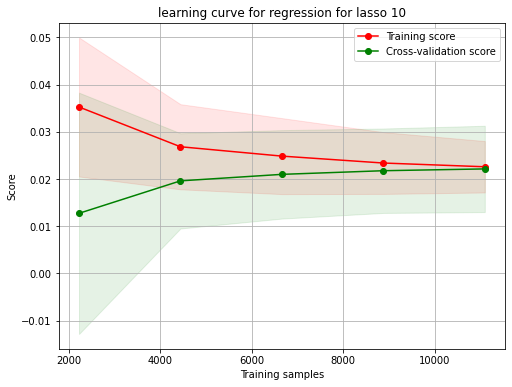

In [ ]:
# Plotting learning curve
from sklearn.linear_model import LinearRegression
X = final_df_lasso_10.values[:, 0:-1]
y = final_df_lasso_10.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                            random_state=0)

regl = LinearRegression()

regl.fit(X_train, y_train)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                    n_jobs=1, train_sizes=np.linspace(0.1, 0.5, 5)):

    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training samples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                     color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
            label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
            label='Cross-validation score')
    plt.legend(loc='best')
    return plt

cv= ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(regl, "learning curve for regression for lasso 10", X_train, y_train,
                     cv=cv, n_jobs=4)



In [ ]:
# Lasso feature selection  dataset 15 features
linearRegAll(final_df_lasso_15, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


100%|██████████| 1000/1000 [00:00<00:00, 1934.54it/s]


weights :  [ 3487.02996139  1135.47398235  1358.64018877 -1412.51722755
  -772.74039524  1061.80942772  -332.80767895   509.81970377
   525.67477386  -319.1713115    525.58643654  -382.41924577
  -222.10895218  -239.5105804    -40.75124085    72.83335424]


RMSE for the test dataset :  8159.308629497251
MAE for the test dataset :  3057.2366345094247





----with Ridge regularization-----
Solving using Gradient Descent
Solving using L2 Ridge regularization


100%|██████████| 1000/1000 [00:00<00:00, 1705.33it/s]

weights :  [ 3487.02978188  1135.47382178  1358.64008683 -1412.51365531
  -772.74023042  1061.80590707  -332.8076983    509.81967987
   525.67473651  -319.17128465   525.58639454  -382.41920824
  -222.10898267  -239.51053728   -40.75124111    72.83334495]


RMSE for the test dataset :  8159.308605553513
MAE for the test dataset :  3057.236493514068






In [ ]:
# PCA feature selection  dataset 95% var
linearRegAll(final_df_95_var_pca, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


 89%|████████▉ | 893/1000 [00:01<00:00, 668.67it/s]


The model stopped learning
weights :  [3487.02996139 -805.91431212   72.42953777  724.46574464 -208.11047737
  203.07778154  743.06505041  269.72925618   73.82756055 -261.20579389
  402.28443719 -244.09359503  175.73696445  133.62390947   38.26746602
   10.66151386 -126.77222623  205.60909598  105.43277199 -159.47954444
 -221.90732931  524.16388458  266.75197455  266.29006803 -316.91797339
  -77.61297947   88.61041522 -322.76395643 -536.55911546 -384.97087694
 -645.38980627 -332.08627101 -308.7821645    68.00249972  151.84240388
  -67.12635332   28.09339718 -119.33656812  -54.56337476  109.07522888
  -12.8127073 ]


RMSE for the test dataset :  8148.972842426289
MAE for the test dataset :  3048.29172390522





----with Ridge regularization-----
Solving using Gradient Descent
Solving using L2 Ridge regularization


 90%|████████▉ | 896/1000 [00:01<00:00, 645.53it/s]

The model stopped learning
weights :  [3487.02978188 -805.91427983   72.42952349  724.46573702 -208.11046597
  203.07778854  743.06503563  269.72925612   73.82756969 -261.20576635
  402.28442336 -244.0935748   175.73695787  133.62391482   38.26745193
   10.66151564 -126.77223165  205.60907825  105.43276525 -159.47954012
 -221.90732013  524.16385485  266.75196057  266.29005637 -316.91796437
  -77.61297438   88.61040717 -322.76385987 -536.5590288  -384.9708035
 -645.38969654 -332.08617165 -308.78209431   68.00250002  151.84239517
  -67.12635015   28.09339547 -119.3365643   -54.56337155  109.07522598
  -12.81270418]


RMSE for the test dataset :  8148.972831534839
MAE for the test dataset :  3048.2916221713563






In [ ]:
# PCA feature selection  dataset 10 num
linearRegAll(final_df_10_num_pca, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


 62%|██████▏   | 616/1000 [00:00<00:00, 934.46it/s]


The model stopped learning
weights :  [3487.02996139 -888.4748406   107.16248036  860.16785486 -198.75438435
  290.42430552  777.29792068  362.07555801    7.51827529 -378.5910663
  390.72621851 -155.92411722 -220.65448694 -241.46934988 -716.21245125
 -266.49133369 -219.55839638   58.01677848  145.94577175  -64.05847631
   41.51632791 -120.31249093  -55.80480305  114.63844541  -31.27510001]


RMSE for the test dataset :  8174.941247919914
MAE for the test dataset :  3038.2484846374773





----with Ridge regularization-----
Solving using Gradient Descent
Solving using L2 Ridge regularization


 62%|██████▏   | 624/1000 [00:00<00:00, 941.94it/s]

The model stopped learning
weights :  [3487.02978188 -888.47472439  107.16245659  860.16769243 -198.75437844
  290.42421809  777.29782456  362.07545304    7.51829521 -378.59098739
  390.72619136 -155.92432263 -220.65476288 -241.46942874 -716.21251238
 -266.49148183 -219.55847915   58.0167793   145.94576416  -64.05847328
   41.516324   -120.31248538  -55.80480084  114.63844286  -31.27509653]


RMSE for the test dataset :  8174.941239846457
MAE for the test dataset :  3038.2483744856845






In [ ]:
# PCA feature selection  dataset 15 num
linearRegAll(final_df_15_num_pca, learningRate=0.00001, tolerance=0.00005)

---without regularization---
Solving using Gradient Descent


 80%|███████▉  | 795/1000 [00:00<00:00, 862.31it/s]


The model stopped learning
weights :  [3487.02996139 -859.03544567   77.05885227  806.72710028 -196.94606987
  257.75761885  766.85892935  324.90537342   20.17925829 -324.21131179
  373.15694529 -179.66164895  189.07696206  122.10678905   50.01413161
   31.29250627 -222.7967268  -376.23730589 -258.92296561 -734.02428835
 -287.31359283 -253.39642398   58.54337819  150.18039857  -67.28146474
   39.86326998 -119.02307158  -56.83033538  115.24404227  -31.14895249]


RMSE for the test dataset :  8176.799139101
MAE for the test dataset :  3049.1232393476985





----with Ridge regularization-----
Solving using Gradient Descent
Solving using L2 Ridge regularization


 79%|███████▉  | 791/1000 [00:01<00:00, 700.81it/s]


The model stopped learning
weights :  [3487.02978188 -859.03544461   77.05883288  806.727151   -196.94605566
  257.75766219  766.85895587  324.90541191   20.17927756 -324.21128653
  373.15693691 -179.66160356  189.07696094  122.10680318   50.01410016
   31.29251513 -222.79649484 -376.23707692 -258.92283244 -734.02408515
 -287.31336497 -253.3962809    58.54337951  150.18038886  -67.28146148
   39.86326784 -119.02306838  -56.83033103  115.24403859  -31.14894727]


RMSE for the test dataset :  8176.799127753907
MAE for the test dataset :  3049.123139915445






<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

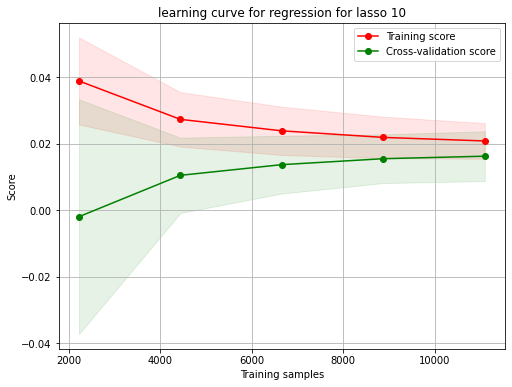

In [ ]:
# Plotting learning curve
from sklearn.linear_model import LinearRegression
X = final_df_15_num_pca.values[:, 0:-1]
y = final_df_15_num_pca.values[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                            random_state=0)

regl = LinearRegression()

regl.fit(X_train, y_train)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                    n_jobs=1, train_sizes=np.linspace(0.1, 0.5, 5)):

    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training samples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                     color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
            label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
            label='Cross-validation score')
    plt.legend(loc='best')
    return plt

cv= ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(regl, "learning curve for regression for lasso 10", X_train, y_train,
                     cv=cv, n_jobs=4)



## Classification Models

### Logistic Regression

In [ ]:
class LogisticRegression:

    def __init__(self, X, y, learningRate, tolerance, maxIteration, batchSize):

        self.X= X
        self.y = y
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.batchSize = batchSize


    def splitData(self):

        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        X_train = self.add_X0(X_train)
        X_valid = self.add_X0(X_valid)
        X_test = self.add_X0(X_test)
        return X_train, X_valid, X_test, y_train, y_valid, y_test

    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def sigmoid(self,z):
        sig = 1 / ( 1 + np.exp(-z))
        return sig

    def predict(self,X):
        pred = self.sigmoid(X.dot(self.w))
        return np.around(pred)

    def costFunction(self, X, y):
        pred =np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w)*y
        cost = pred.sum( )
        return cost

    def gradient(self,X,y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig -y ).dot(X)
        return grad

    def gradientDescent(self, X, y):
        errors = []
        last = float('inf')

        for i in range(self.maxIteration):
            self.w = self.w - self.learningRate*self.gradient(X,y)
            curr = self.costFunction(X,y)

            diff = last - curr
            #last - curr
            last = curr

            errors.append(curr)

            if diff < self.tolerance:
                print("The model stopped Learning")
                break
        # self.plot_cost(errors)

    def stochasticGD(self, X, y):
        X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
        XY = np.c_[X.reshape(X.shape[0], X.shape[1]), y.reshape(X.shape[0], 1)]


        # Set seed
        np.random.seed(2022)
        errors = []

        for i in tqdm(range(self.maxIteration)):

        # Shuffle x and y
            np.random.shuffle(XY)

            start = 0
            stop = start + self.batchSize
            X_batch, y_batch = XY[start:stop, :-1], XY[start:stop, -1]


            last_error = float('inf')

          # Recalculating the difference
            self.w = self.w - self.learningRate * self.gradient(X_batch, y_batch)
            current_error = self.costFunction(X, y)

            diff = last_error - current_error
            last_error = current_error

            errors.append(current_error)
            if np.abs(diff) < self.tolerance:
                print('Model stopped learning')
                break

        print(self.w)


    def evaluate(self, y, y_hat):

        y = (y == 1)
        y_hat = (y_hat == 1)

        #accuracy = np.sum(np.equal(y_true, y_hat)) / len(y_true)
        accuracy = (y == y_hat).sum() / y.size
        #precision = (y & y_hat).sum() / y_hat.sum()
        #recall = (y & y_hat).sum() / y.sum()


        return accuracy

    def fit(self):

        X_train, X_valid, X_test, y_train, y_valid, y_test = self.splitData()
        self.w = np.dot(np.ones(X_train.shape[1], dtype = np.float64), 0)
        self.stochasticGD(X_train, y_train)
        # self.gradientDescent(X_train, y_train)
        y_hat_train = self.predict(X_train)
        accuracy = self.evaluate(y_train,y_hat_train)
        return accuracy

    def validation(self):
        X_train, X_valid, X_test, y_train, y_valid, y_test = self.splitData()
        y_hat_valid = self.predict(X_valid)

        accuracy = self.evaluate(y_valid, y_hat_valid)
        return accuracy

    def test(self):
        X_train, X_valid, X_test, y_train, y_valid, y_test = self.splitData()
        y_hat_test = self.predict(X_test)
        accuracy  = self.evaluate(y_test, y_hat_test)
        return accuracy

In [ ]:
#Baseline - 1st dataset (dataframe with transformation + scaling)

lr = LogisticRegression(X_O, y_O, learningRate = 0.001, tolerance = 0.001, maxIteration = 1000, batchSize=128)
log_base_train_acc = lr.fit()
log_base_valid_acc = lr.validation()
log_base_test_acc = lr.test()
display(log_base_train_acc, log_base_valid_acc, log_base_test_acc)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.76it/s]


[ 0.16180703 -0.00124695  0.023703    0.03512455 -0.12149746  0.11362724
 -0.16294482  0.05690156  0.07627861 -0.05358045  0.05162718 -0.01414459
 -0.07071139 -0.21565786 -0.0922085  -0.2314389   0.62738386  0.19867212
  0.08082063  0.1532507  -0.06052038 -0.08136888  0.02301493  0.05095196
  0.10704704 -0.01387051  0.00090875  0.01881799 -0.00386488 -0.09712463
 -0.00232047 -0.0989938  -0.01236307 -0.00356415  0.07470942 -0.04417878
  0.07636777  0.0518481   0.07841203  0.03035425  0.48542526 -0.20834968
 -0.17128688 -0.48976333 -0.04849721  0.51906452  0.55406835 -0.06086925
 -0.18791543 -0.19659005 -0.04966977  0.10278317  0.36797265  0.1860957 ]


0.6600900900900901

0.6493693693693694

0.6495712123759879

In [ ]:
learning_rate = [0.001, 0.0001, 0.01]
log_base_valid_acc_dict = {}
for lrate in learning_rate:
    lr = LogisticRegression(X, y, learningRate = lrate, tolerance = 0.001, maxIteration = 1000, batchSize=128)
    log_base_train_acc = lr.fit()
    log_base_valid_acc = lr.validation()
    log_base_test_acc = lr.test()
    # display(log_base_train_acc, log_base_valid_acc, log_base_test_acc)
    log_base_valid_acc_dict[lrate] = log_base_valid_acc

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.63it/s]


[ 0.15443128 -0.13217783  0.11413342  0.06854624 -0.05007308 -0.05890672
  0.10887983  0.040427   -0.00653599 -0.15071693  0.27710884 -0.15178731
 -0.0842135   0.00382971 -0.01873911 -0.00426486  0.01636536  0.19051299
 -0.01187053  0.05806563 -0.04634089  0.2664785   0.18024302  0.17973407
 -0.2493821  -0.10865165  0.09905742  0.44292097 -0.21968997 -0.06318302
 -0.48006396 -0.35645511  0.4896647   0.69160611  0.04477607 -0.12834609
 -0.17265302 -0.24380591 -0.03714588  0.43084982  0.2607563 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.37it/s]


[ 0.11308239 -0.09153594  0.11030713  0.08717913 -0.03559326 -0.05196592
  0.15696919  0.01331789  0.07771416 -0.1489579   0.23964855 -0.18758847
 -0.09216708 -0.03410216 -0.04710634  0.00800819  0.00803376  0.12001937
 -0.02193883  0.01156184 -0.05641466  0.18039868  0.10147415  0.12048674
 -0.16082614 -0.07291715  0.0515898   0.14777608 -0.06561053  0.00939796
 -0.1535639  -0.04491423  0.12498708  0.28241018  0.00885411 -0.02692389
 -0.06012531 -0.08349905 -0.00763365  0.15351251  0.12889767]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.41it/s]

[ 0.13696953 -0.20061054  0.18080496 -0.00800523 -0.1528799  -0.09716984
  0.25378306 -0.01443665 -0.030998   -0.03831557  0.17088457 -0.10069535
 -0.08784842  0.13216502 -0.0975964   0.0618874  -0.03885393  0.27183073
  0.1108346   0.11449138  0.05603907  0.31273826  0.20131615  0.19127485
 -0.32597715 -0.05786823  0.15937273  0.41184554 -0.266612   -0.12432912
 -0.69948457 -0.57478539  0.52862856  0.74637925 -0.01966814 -0.13727027
 -0.20726423 -0.19511921 -0.05008787  0.47952807  0.26685118]


In [ ]:
log_base_valid_acc_dict

{0.001: 0.6435714285714286,
 0.0001: 0.6371428571428571,
 0.01: 0.6371428571428571}

In [ ]:
#2nd dataset (dataframe with transformation + scaling + outlier treatment)

lr = LogisticRegression(X, y, learningRate = 0.001, tolerance = 0.001, maxIteration = 1000, batchSize=128)
log_base_train_acc = lr.fit()
log_base_valid_acc = lr.validation()
log_base_test_acc = lr.test()
display(log_base_train_acc, log_base_valid_acc, log_base_test_acc)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.83it/s]


[ 0.16460632  0.00377639 -0.01952288  0.00087789 -0.15319947  0.11170408
 -0.15326431  0.04925518  0.07986434 -0.06833536  0.0664831  -0.00462466
 -0.08290767 -0.24153927 -0.09715222 -0.10782466  0.68144818  0.22247413
  0.07258027  0.15729152 -0.06973866 -0.06269718 -0.01692134  0.05526195
  0.12288945  0.03818719 -0.02956034  0.04220259 -0.00702701 -0.11207474
 -0.04212383 -0.10367928 -0.00509118  0.00625496  0.05813173 -0.04616039
  0.06947752  0.06826766  0.07535566  0.02578673  0.50328321 -0.18078203
 -0.18753428 -0.4476995  -0.02386038  0.50489056  0.55579758 -0.07294367
 -0.18444611 -0.1946321  -0.04870049  0.10953111  0.36626521  0.18953237]


0.6618918918918919

0.650990990990991

0.651925340507819

In [ ]:
# Lasso feature selection  dataset 10 features
final_df_lasso_10['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

X_l10 = final_df_lasso_10.drop(['popularity'], axis = 1)
y_l10 = final_df_lasso_10['popularity']

In [ ]:
# Lasso feature selection  dataset 15 features

final_df_lasso_15['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

X_l15 = final_df_lasso_15.drop(['popularity'], axis = 1)
y_l15 = final_df_lasso_15['popularity']

In [ ]:
# PCA feature selection  dataset 95% var

final_df_95_var_pca['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

X_p95 = final_df_95_var_pca.drop(['popularity'], axis = 1)
y_p95 = final_df_95_var_pca['popularity']

In [ ]:
# PCA feature selection  dataset 10 num

final_df_10_num_pca['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

X_p10 = final_df_10_num_pca.drop(['popularity'], axis = 1)
y_p10 = final_df_10_num_pca['popularity']

In [ ]:
# PCA feature selection  dataset 15 num

final_df_15_num_pca['popularity'] = onp['shares'].apply(lambda x: 0 if x < median else 1)

X_p15 = final_df_15_num_pca.drop(['popularity'], axis = 1)
y_p15 = final_df_15_num_pca['popularity']

### Gaussian Naive Bayes

In [ ]:
class GaussianNaiveBayes:

    def fitDistribution(self, data):
        mean = np.mean(data)
        std = np.std(data)
        dist = norm(mean,std)
        return dist

    def probability(self, x, y, prior):
        prob = prior
        for col in X_train.columns:
            prob *= self.distributions[y][col].pdf(x[col])
        return prob

    def fit(self, X_train, y_train):

        self.distributions = {0:{},1:{}}

        X0_train = X_train.iloc[np.where(y_train == 0)[0]]
        X1_train = X_train.iloc[np.where(y_train == 1)[0]]

        self.prior0 = len(X0_train) / len(X_train)
        self.prior1 = len(X1_train) / len(X_train)

        for col in X_train.columns:
            self.distributions[0][col] = self.fitDistribution(X0_train[col])
            self.distributions[1][col] = self.fitDistribution(X1_train[col])

    def train(self, X_train, y_train):
        y_hat_train = []
        for idx in X_train.index:
              # posterior is updated based on probabilites of test values
            py_0 = self.probability(X_train.loc[idx, :], 0, self.prior0)
            py_1 = self.probability(X_train.loc[idx, :], 1, self.prior1)
            y_hat_train.append(np.argmax([py_0,py_1]))

        acc_tr = np.sum(np.equal(y_train, y_hat_train)) / len(y_train)
        return acc_tr

    def validation(self, X_valid, y_valid):

        y_hat_valid = []
        for idx in X_valid.index:
              # posterior is updated based on probabilites of test values
            py_0 = self.probability(X_valid.loc[idx, :], 0, self.prior0)
            py_1 = self.probability(X_valid.loc[idx, :], 1, self.prior1)
            y_hat_valid.append(np.argmax([py_0,py_1]))

        acc_va = np.sum(np.equal(y_valid, y_hat_valid)) / len(y_valid)
        return acc_va

    def test(self, X_test, y_test):

        y_hat_test = []
        for idx in X_test.index:
                # posterior is updated based on probabilites of test values
            py_0 = self.probability(X_test.loc[idx, :], 0, self.prior0)
            py_1 = self.probability(X_test.loc[idx, :], 1, self.prior1)
            y_hat_test.append(np.argmax([py_0,py_1]))

        acc_te = np.sum(np.equal(y_test, y_hat_test)) / len(y_test)
        return acc_te

In [ ]:
#Baseline - 1st dataset (dataframe with transformation + scaling)

X_train, X_test, y_train, y_test = train_test_split(X_O, y_O, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.6205045045045045

0.611568858247856

In [ ]:
#2nd dataset (dataframe with transformation + scaling + outlier treatment)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.6262342342342342

0.6185471666386413

In [ ]:
# Lasso feature selection  dataset 10 features

X_train, X_test, y_train, y_test = train_test_split(X_l10, y_l10, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.905009009009009

0.9060030267361695

In [ ]:
# Lasso feature selection  dataset 15 features

X_train, X_test, y_train, y_test = train_test_split(X_l15, y_l15, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.896972972972973

0.8987724903312595

In [ ]:
# PCA feature selection  dataset 95% var

X_train, X_test, y_train, y_test = train_test_split(X_p95, y_p95, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.8528288288288288

0.8550529678829663

In [ ]:
# PCA feature selection  dataset 10 num

X_train, X_test, y_train, y_test = train_test_split(X_p10, y_p10, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.8522522522522522

0.8548848158735497

In [ ]:
# PCA feature selection  dataset 15 num

X_train, X_test, y_train, y_test = train_test_split(X_p15, y_p15, test_size=0.3, random_state=42)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

In [ ]:
gnb_train_accuracy = gnb.train(X_train, y_train)
gnb_test_accuracy = gnb.test(X_test, y_test)

display(gnb_train_accuracy, gnb_test_accuracy)

0.8527567567567568

0.8561459559441735

### Soft-Margin Support Vector Machine

In [ ]:
class MaxMarginClassifier:

    def __init__(self, C):
        self.alpha = None
        self.w = None
        self.C = C

    def fit(self, X, y):

        N = len(y)
        #Gram matrix
        Xy = X*y[:, np.newaxis] # newmatrix converts a vector into matrix
        GramXy = np.matmul(Xy, Xy.T)


        def Ld0(G, alpha):
            obj_fn = alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
            return obj_fn

        def partialDerivativeLd0(G, alpha):
            par_der = np.ones_like(alpha) - alpha.dot(G)
            return par_der

        #initialize x0 = alphas

        alpha = np.ones(N)
        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.concatenate((np.zeros(N), self.C * np.ones(N)))

        constraints = ({'type': 'eq', 'fun': lambda a: np.dot(a,y), 'jac': lambda a:y},
                       {'type': 'ineq', 'fun': lambda a: b-np.dot(A,a), 'jac': lambda a:-A})




        optRes = optimize.minimize(fun = lambda a: -Ld0(GramXy, a),
                                   x0 = alpha,
                                   jac = lambda a: -partialDerivativeLd0(GramXy, a),
                                   constraints = constraints
                                   )

        self.alpha = optRes.x

        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis = 0)

        epsilon = 1e-4
        self.supportVectors = X[self.alpha > epsilon]
        self.supportLabels = y[self.alpha > epsilon]

        b = []
        for i in range(len(self.supportLabels)):
            b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
            b.append(b_i)
        self.b = sum(b)/len(b)

    def predict(self, X):
        pred_ = np.dot(X, self.w) + self.b
        return np.sign(pred_)


In [ ]:
#Baseline - 1st dataset (dataframe with transformation + scaling)

subset_O = final_onp_with_outliers.sample(n=2500)

X_sub = subset_O.drop(['popularity'], axis = 1)
y_sub = subset_O['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)


0.6019047619047619

In [ ]:
display (svm_train_accuracy, svm_valid_accuracy, svm_test_accuracy)

0.6857142857142857

0.6019047619047619

0.6306666666666667

In [ ]:
#2nd dataset (dataframe with transformation + scaling + outlier treatment)

subset = final_onp_without_outliers.sample(n=2500)

X_sub = subset.drop(['popularity'], axis = 1)
y_sub = subset['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)
display (svm_train_accuracy, svm_valid_accuracy, svm_test_accuracy)

0.6620408163265306

0.6438095238095238

0.6373333333333333

In [ ]:
# Lasso feature selection  dataset 10 features

subset_l10 = final_df_lasso_10.sample(n=1000)

X_sub = subset_l10.drop(['popularity'], axis = 1)
y_sub = subset_l10['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)

In [ ]:
# Lasso feature selection  dataset 15 features

subset_l15 = final_df_lasso_15.sample(n=2500)

X_sub = subset_l15.drop(['popularity'], axis = 1)
y_sub = subset_l15['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)

In [ ]:
# PCA feature selection  dataset 95% var

subset_p95 = final_df_95_var_pca.sample(n=2500)

X_sub = subset_p95.drop(['popularity'], axis = 1)
y_sub = subset_p95['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)

In [ ]:
# PCA feature selection  dataset 10 num

subset_p10 = final_df_10_num_pca.sample(n=2500)

X_sub = subset_p10.drop(['popularity'], axis = 1)
y_sub = subset_p10['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)

In [ ]:
# PCA feature selection  dataset 15 num

subset_p15 = final_df_15_num_pca.sample(n=2500)

X_sub = subset_p15.drop(['popularity'], axis = 1)
y_sub = subset_p15['popularity']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_sub, y_train_sub, test_size=0.3, random_state=42)
X_train_arr = np.asarray(X_train_sub)
y_train_arr = np.where(y_train_sub==0, -1, 1)
X_valid_arr = np.asarray(X_valid_sub)
y_valid_arr = np.where(y_valid_sub==0, -1, 1)
X_test_arr = np.asarray(X_test_sub)
y_test_arr = np.where(y_test_sub==0, -1, 1)
model = MaxMarginClassifier(C = 5)

model.fit(X_train_arr, y_train_arr)

In [ ]:
svm_train_accuracy = np.sum(model.predict(X_train_arr) == y_train_arr) / np.size(y_train_arr)
svm_valid_accuracy = np.sum(model.predict(X_valid_arr) == y_valid_arr) / np.size(y_valid_arr)
svm_test_accuracy = np.sum(model.predict(X_test_arr) == y_test_arr) / np.size(y_test_arr)
display (svm_train_accuracy, svm_valid_accuracy, svm_test_accuracy)

0.6155102040816327

0.6628571428571428

0.6493333333333333

### Neural Networks

In [ ]:
!pip install scikeras

from sklearn.metrics import accuracy_score

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Neural networks model with 2 nodes
from pandas.core.common import random_state
# baseline model
def create_baseline(input_size):
    # create model
    model = Sequential()
    model.add(Dense(60, input_shape=(input_size,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Neural networks model with 6 layers, 4 dense layers and 2 dropout
def create_complex(input_size):
    # create model
    model = Sequential()
    model.add(Dense(128, input_shape=(input_size,), activation='relu',))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='sigmoid'))
    # model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
#Baseline - 1st dataset (dataframe with transformation + scaling)
subset_O = final_onp_with_outliers.sample(n=10000)

#2nd dataset (dataframe with transformation + scaling + outlier treatment)
subset = final_onp_without_outliers.sample(n=10000)

In [ ]:
# running neural networks model for baseline dataset
X = subset_O.drop(['popularity'], axis = 1)
y = subset_O['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]

estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)


print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.9228571428571428  validation accuracy:  0.5819047619047619 test accuracy:  0.6016666666666667
NN Model 2
train accuracy : 0.8726530612244898  validation accuracy:  0.62 test accuracy:  0.6343333333333333


In [ ]:
# running neural networks model for (dataframe with transformation + scaling + outlier treatment)
X = subset.drop(['popularity'], axis = 1)
y = subset['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]

estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)


print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.9351020408163265  validation accuracy:  0.6190476190476191 test accuracy:  0.5923333333333334
NN Model 2
train accuracy : 0.8904081632653061  validation accuracy:  0.6361904761904762 test accuracy:  0.6306666666666667


In [ ]:
# pca datasets sampling
final_df_10_num_pca_nn=None
final_df_10_num_pca_nn=final_df_10_num_pca
final_df_95_var_pca_nn=final_df_95_var_pca
final_df_15_num_pca_nn=final_df_15_num_pca


In [ ]:

final_df_10_num_pca_nn['popularity'] = final_df_10_num_pca['shares'].apply(lambda x: 0 if x <1400 else 1)
final_df_10_num_pca_nn_1= pd.DataFrame(final_df_10_num_pca_nn.drop(columns='shares',axis=1))
final_df_10_num_pca_sample = final_df_10_num_pca_nn_1.sample(n=10000)

final_df_95_var_pca_nn['popularity'] = final_df_10_num_pca['shares'].apply(lambda x: 0 if x <1400 else 1)
final_df_95_var_pca_nn_2=final_df_95_var_pca_nn.drop(columns='shares',axis=1)
final_df_95_var_pca_sample = final_df_95_var_pca_nn_2.sample(n=10000)

final_df_15_num_pca_nn['popularity'] = final_df_10_num_pca['shares'].apply(lambda x: 0 if x <1400 else 1)
final_df_15_num_pca_nn_3=final_df_15_num_pca_nn.drop(columns='shares',axis=1)
final_df_15_num_pca_sample = final_df_15_num_pca_nn_3.sample(n=10000)

In [ ]:
# running neural networks model for pca dataset with 10 numerical variables
X = final_df_10_num_pca_sample.drop(['popularity'], axis = 1)
y = final_df_10_num_pca_sample['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]
estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)

print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.7881632653061225  validation accuracy:  0.611904761904762 test accuracy:  0.6056666666666667
NN Model 2
train accuracy : 0.776734693877551  validation accuracy:  0.621904761904762 test accuracy:  0.624


In [ ]:
# running neural networks model for pca dataset with 95% variance dataset

X = final_df_95_var_pca_sample.drop(['popularity'], axis = 1)
y = final_df_95_var_pca_sample['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]

estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)


print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.8951020408163265  validation accuracy:  0.5723809523809524 test accuracy:  0.5956666666666667
NN Model 2
train accuracy : 0.8585714285714285  validation accuracy:  0.6185714285714285 test accuracy:  0.6193333333333333


In [ ]:
# running neural networks model for pca dataset with 15 numerical variables
X = final_df_15_num_pca_sample.drop(['popularity'], axis = 1)
y = final_df_15_num_pca_sample['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]

estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)


print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.8330612244897959  validation accuracy:  0.5957142857142858 test accuracy:  0.5813333333333334
NN Model 2
train accuracy : 0.7932653061224489  validation accuracy:  0.6133333333333333 test accuracy:  0.611


In [ ]:
# implementing NN on lasso datasets

final_df_lasso_10_nn = final_df_lasso_10
final_df_lasso_15_nn = final_df_lasso_15


final_df_lasso_10_nn['popularity'] = final_df_lasso_10['shares'].apply(lambda x: 0 if x <1400 else 1)
final_df_lasso_10_nn_1= pd.DataFrame(final_df_lasso_10_nn.drop(columns='shares',axis=1))
final_df_lasso_10_nn_sample = final_df_lasso_10_nn_1.sample(n=10000)

final_df_lasso_15_nn['popularity'] = final_df_lasso_15['shares'].apply(lambda x: 0 if x <1400 else 1)
final_df_lasso_15_nn_2=final_df_lasso_15_nn.drop(columns='shares',axis=1)
final_df_lasso_15_nn_sample = final_df_lasso_15_nn_2.sample(n=10000)

In [ ]:
# running neural networks model for lasso 10 dataset

X = final_df_lasso_10_nn_sample.drop(['popularity'], axis = 1)
y = final_df_lasso_10_nn_sample['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]

estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)


print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.6777551020408163  validation accuracy:  0.6228571428571429 test accuracy:  0.628
NN Model 2
train accuracy : 0.6748979591836735  validation accuracy:  0.6285714285714286 test accuracy:  0.6416666666666667


In [ ]:
# running neural networks model for lasso 15 dataset

X = final_df_lasso_15_nn_sample.drop(['popularity'], axis = 1)
y = final_df_lasso_15_nn_sample['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
input_size=X_train.shape[1]

estimator = KerasClassifier(model=create_baseline(input_size), epochs=100, batch_size=5, verbose=0)
estimator.fit(X=X_train, y=y_train)


print('NN Model 1')
print('train accuracy :', accuracy_score(estimator.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator.predict(X_test), y_test))

estimator2 = KerasClassifier(model=create_complex(input_size), epochs=100, batch_size=5, verbose=0)
estimator2.fit(X=X_train, y=y_train)

print('NN Model 2')
print('train accuracy :', accuracy_score(estimator2.predict(X_train), y_train),\
      ' validation accuracy: ', accuracy_score(estimator2.predict(X_valid), y_valid), \
      'test accuracy: ', accuracy_score(estimator2.predict(X_test), y_test))

NN Model 1
train accuracy : 0.7308163265306122  validation accuracy:  0.6152380952380953 test accuracy:  0.5976666666666667
NN Model 2
train accuracy : 0.7275510204081632  validation accuracy:  0.6357142857142857 test accuracy:  0.612
